# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [1]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

from jax import config

config.update("jax_enable_x64", True)

## Initializing the PINN

In [2]:
from utils import data_path

file = data_path / "poisson_smooth_train.json"
file_test = data_path / "poisson_smooth_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

We visualize the points of the domain decomposition.

(684, 2)
(120, 2)
(216, 2)
(80, 2)


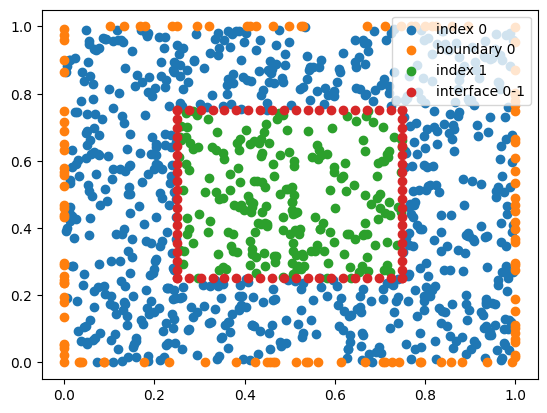

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [4]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


def boundary_loss_factory(target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss

In [5]:
def interior_loss_factory(index: int, rhs: Callable[[Array], Array]) -> LFunc:
            
    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) + rhs(x)

    v_residual = jit(vmap(residual, (None, 0)))#vmap(residual, (None, 0))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

In [6]:
@jit
def u_star(x):
    return np.prod(np.sin(np.pi * x))

# rhs
@jit
def f(x):
    return 2. * np.pi**2 * u_star(x)

f_v = f
f_final = jit(f_v)

Setting the boundary and interior loss

In [7]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0.0)

p0.interior_loss = interior_loss_factory(0, f)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, f)

Setting the interface loss

In [8]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [9]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [10]:
shapes = [[2] + [64] + [1],[2] + [64] + [64] + [1]]
exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)

In [11]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 313.66040782061935
10.00% iter = 20000 of 200000: Total loss = 0.09578404832484451


Text(0.5, 1.0, 'Loss per Pinn over 200000 epochs')

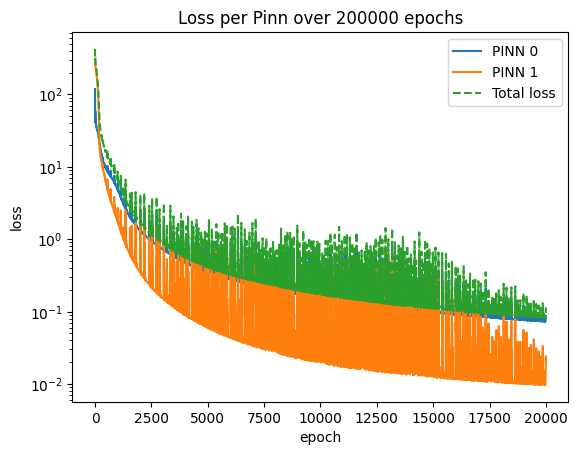

In [ ]:
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [ ]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

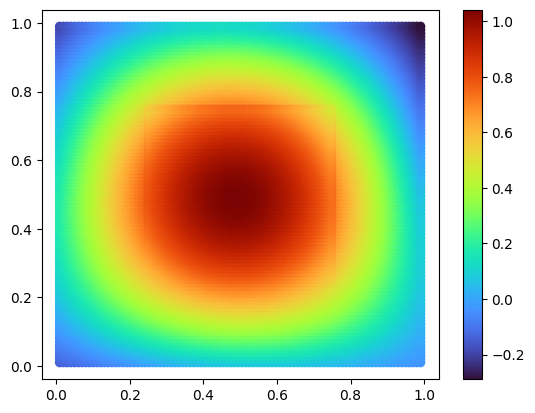

In [ ]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [ ]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)

print(total_points)
min_, max_ = total_pred.min(), total_pred.max()
true_value = np.sin(np.pi * total_points[:, 0]) * np.sin(np.pi * total_points[:, 1])
# true_value
true_value = true_value.reshape(total_pred.shape)

[[0.01010101 0.01010101]
 [0.02020202 0.01010101]
 [0.03030303 0.01010101]
 ...
 [0.72727275 0.74747473]
 [0.73737371 0.74747473]
 [0.74747473 0.74747473]]


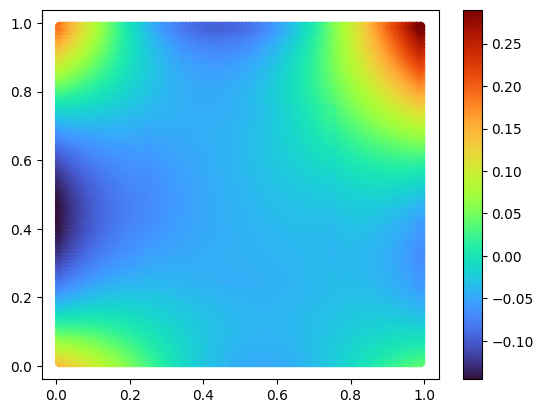

In [ ]:
plt.scatter(total_points[:, 0], total_points[:, 1], c=true_value-total_pred, cmap="turbo")
plt.colorbar()

In [ ]:
### L2 normalization 
# Values in x to evaluate the integral.
n = int(np.sqrt(total_points.shape[0]))
X = total_points[:, 0]
Y = total_points[:, 1]

X = X.reshape(n, n)
Y = Y.reshape(n, n)

total_pred=total_pred.reshape(n,n)
true_value= true_value.reshape(n,n)

inner = onp.trapz((total_pred-true_value)**2, total_points[0:n,0], axis=0)
outer = onp.trapz(inner, total_points[::n,1], axis=0)
l2_err = np.sqrt(outer)
normalizer = np.sqrt(onp.trapz(onp.trapz((true_value)**2, total_points[0:n,0], axis=0),total_points[::n,1], axis=0))
print(l2_err/normalizer)

0.14870665096447913


In [ ]:
### Rel L2 norms 900 interior, 120 boundary, 80 interface
#0.14870665096447913